# Fast Bernoulli: Report Benchmarks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from json import load

In [3]:
with open('../doc/benchmark.json') as fin:
    obj = load(fin)

In [4]:
benchmarks = pd.DataFrame(obj['benchmarks'])
benchmarks.head()

,name,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,bytes_per_second
0,BM_Executor<NFastBernoulli::TGeneralExecutor>,BM_Executor<NFastBernoulli::TGeneralExecutor>,iteration,0,0,1,1343419,514.373486,514.104576,ns,NaN
1,BM_Executor<NFastBernoulli::TAvxExecutor>,BM_Executor<NFastBernoulli::TAvxExecutor>,iteration,0,0,1,3899981,179.565124,179.485992,ns,NaN
2,BM_RandomNumberGeneration/1,BM_RandomNumberGeneration/1,iteration,0,0,1,17262529,41.460078,41.431537,ns,7.723585e+08
3,BM_RandomNumberGeneration/2,BM_RandomNumberGeneration/2,iteration,0,0,1,8940608,78.320770,77.915795,ns,8.213996e+08
4,BM_RandomNumberGeneration/4,BM_RandomNumberGeneration/4,iteration,0,0,1,4568154,152.563545,152.483855,ns,8.394331e+08


In [5]:
benchmarks.drop(index=[0, 1], inplace=True)
benchmarks['metric'] = benchmarks.name.str.split('/', 1).str.get(0).str.split('_', 1).str.get(1)
benchmarks['noblocks'] = pd.to_numeric(benchmarks.name.str.split('/', 1).str.get(1))

In [6]:
def prettify_label(label):
    if label == 'RandomNumberGeneration':
        return 'MT19937'
    
    avx = 'Avx' in label
    jit = 'Jit' in label
    std = 'Std' in label
    
    if std:
        return 'Std Bernoulli (\~100kbps)'
    
    label = 'Fast Bernoulli'
    if avx:
        label += ' + AVX'
    if jit:
        label += ' + JIT'
    return label

In [7]:
grp = benchmarks.groupby('metric')
combined = pd.concat([
    grp['noblocks'].apply(list),
    grp['cpu_time'].apply(list),
    grp['bytes_per_second'].apply(list),
], ignore_index=False, axis=1,  join='inner').reset_index()
combined['label'] = combined.metric.apply(prettify_label)
combined.drop(columns=['metric'], inplace=True)
combined.set_index('label', inplace=True)
combined = combined.sort_index()

In [8]:
MARKERS = ['<', 'v', '^', '>', '*']

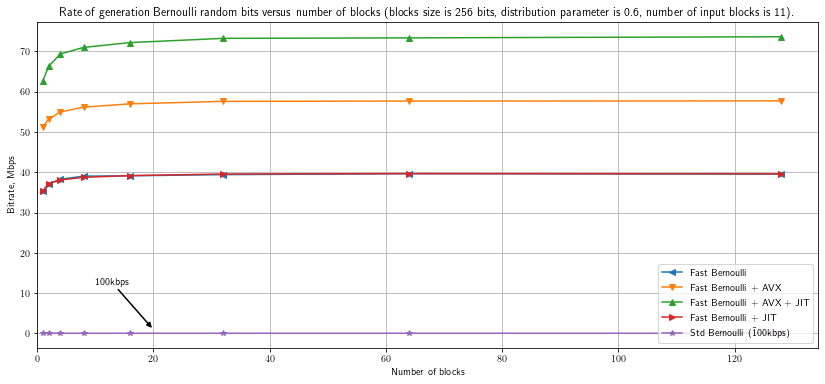

In [9]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 1, 1)
cnt = 0

for label, (params, cpu_time, throughput) in combined.iterrows():
    if 'MT' in label:
        continue
    ax.plot(params, np.array(throughput) / 1e6, marker=MARKERS[cnt], label=label)
    cnt += 1

ax.annotate('~100kbps', xy=(20, 1), xytext=(10, 12),
            arrowprops=dict(arrowstyle='-|>', fc='k', ec='k', lw=1.5),
            bbox=dict(pad=1, facecolor='none', edgecolor='none'))

ax.grid()
ax.legend()
ax.set_xlabel('Number of blocks')
ax.set_ylabel('Bitrate, Mbps')
ax.set_xlim(0)
ax.set_title('Rate of generation Bernoulli random bits versus '
             'number of blocks (blocks size is 256 bits, distribution parameter is 0.6, '
             'number of input blocks is 11).')

fig.savefig('../doc/benchmark-rate-vs-noblocks.png')
plt.show()